## 1. Get the Data
we will be using the `MNIST dataset`, which is a set of `70,000
small images of digits handwritten` by high school students and employees of
the US Census Bureau.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Load DATA

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist.data, mnist.target

---------------------------
##### There are `70,000 images`, and each image has `784 features`. This is because each image is `28 × 28 pixels`, and each feature simply represents one pixel’s intensity, `from 0 (white) to 255 (black)`.

In [5]:
print(X.shape)
print(y)

(70000, 784)
['5' '0' '4' ... '4' '5' '6']


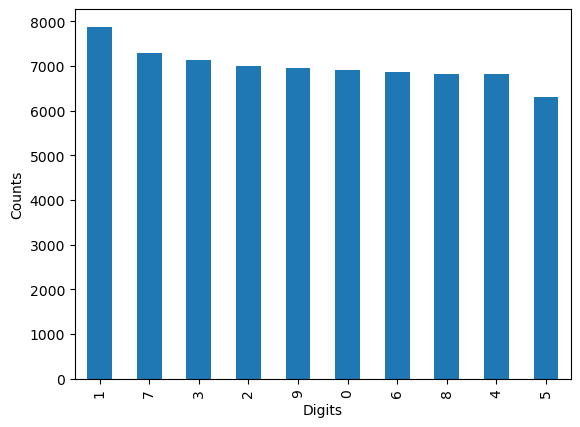

In [160]:
# check data is balanced or not 
pd.Series(y).value_counts().plot(kind='bar')
plt.xlabel('Digits')
plt.ylabel('Counts')
plt.show()

In [162]:
# Balanced: Ratio close to 1 (e.g., 0.8 to 1.0).
# Imbalanced: Ratio < 0.5 (e.g., 0.1 means 1:10 imbalance).
unique, counts = np.unique(y, return_counts=True)
minority_class = min(counts)
majority_class = max(counts)
imbalance_ratio = minority_class / majority_class

print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

Imbalance Ratio: 0.80


##### OK, We have a balanced dataset, let's go

----------------------------------------------------------------------
#####  All we need to do is grab an instance’s feature vector, `reshape` it to a 28 × 28 array, and display it using Matplotlib’s `imshow()` function. We use `cmap="binary"` to get a grayscale color map where 0 is white and 255 is black:

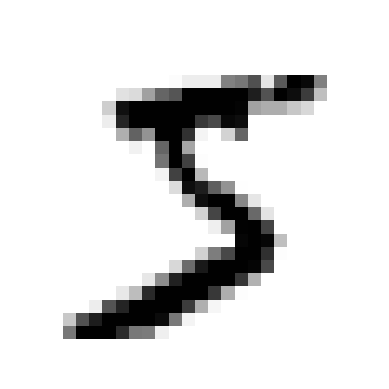

In [12]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')
some_digit = X[0]
plot_digit(some_digit)
plt.show()

##### The MNIST dataset returned by `fetch_openml()` is actually already split into a `training set (the first 60,000 images)` and a `test set (the last 10,000 images)`

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train.shape

(60000,)

## 2. Train the Model
we use `KNeighborsClassifier` because is `instance-base` algorithm and goods for this dataset

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [6]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
# y_pred = knn_clf.predict(X_test)
baseline_accuracy = knn_clf.score(X_test, y_test)
print(baseline_accuracy)

0.9688


In [7]:
param_grid = [{
    'weights': ['uniform', 'distance'],
    'n_neighbors' : [3, 4, 5, 6]
}]
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

,estimator,KNeighborsClassifier()
,param_grid,"[{'n_neighbors': [3, 4, ...], 'weights': ['uniform', 'distance']}]"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,4


In [8]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [9]:
grid_accuracy = grid_search.score(X_test, y_test)
print(grid_accuracy)

0.9714


## 3. Error Analyst

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler

In [11]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [12]:
y_train_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)

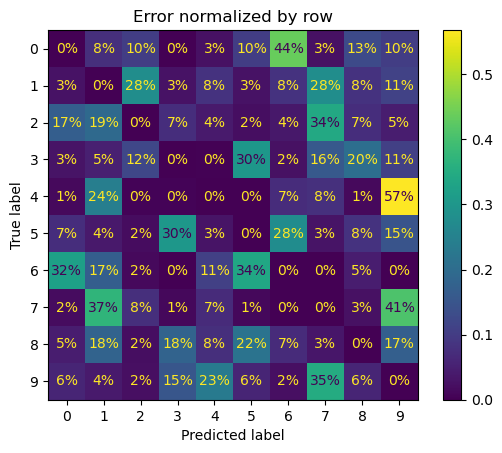

In [13]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='true', 
                                        sample_weight=sample_weight,
                                        values_format='.0%')
plt.title("Error normalized by row")
plt.show()

## 4. Data Augmentation

In [14]:
from scipy.ndimage import shift

In [15]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode='constant')
    return shifted_image.reshape([-1])

In [16]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [17]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [18]:
knn_clf.fit(X_train_augmented, y_train_augmented)
X_train_augmented.shape

(300000, 784)

In [19]:
augmented_accuracy =  knn_clf.score(X_test, y_test)
augmented_accuracy

0.9763

In [21]:
error_rate_change = (1 - augmented_accuracy) / (1 - grid_accuracy) - 1
print(f"Error rate change: {error_rate_change: .0%}")

Error rate change: -17%


The error rate droped after data augmentation